### Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings ; warnings.filterwarnings('ignore')

### Read Data

In [2]:
# 분야별 데이터셋 내 다중공선성 해결을 위해 각각 불러온다.
target = pd.read_csv('../data/target.csv')

pop = pd.read_csv('../data/인구정보_seoul.csv')
live = pd.read_csv('../data/주거정보_seoul.csv')
economic = pd.read_csv('../data/경제정보_seoul.csv')

GJ_pop = pd.read_csv('../data/인구정보_gwangjin.csv')
GJ_live = pd.read_csv('../data/주거정보_gwangjin.csv')
GJ_economic = pd.read_csv('../data/경제정보_gwangjin.csv')

### Normalized Data

In [4]:
columns = [i for i in pop.columns if i not in ['자치구', '년도','행정동']]
pop[columns] = pd.DataFrame(normalize(pop[columns], axis=0), dtype='f')
GJ_pop[columns] = pd.DataFrame(normalize(GJ_pop[columns], axis=0), dtype='f')

columns = [i for i in live.columns if i not in ['자치구', '년도','행정동']]
live[columns] = pd.DataFrame(normalize(live[columns], axis=0), dtype='f')
GJ_live[columns] = pd.DataFrame(normalize(GJ_live[columns], axis=0), dtype='f')

columns = [i for i in economic.columns if i not in ['자치구', '년도','행정동']]
economic[columns] = pd.DataFrame(normalize(economic[columns], axis=0), dtype='f')
GJ_economic[columns] = pd.DataFrame(normalize(GJ_economic[columns], axis=0), dtype='f')

In [5]:
# 선택된 변수들로 데이터를 병합한다.
seoul = target.merge(pop.rename(columns={'1인세대수':'one세대수'}), on=['자치구','년도'])\
        .merge(live, on=['자치구','년도']).merge(economic, on=['자치구','년도'])

# 예년의 값으로 후년의 쓰레기량을 설명하는 통계 모델을 만들고 예측값을 위험지표로 사용하고자 한다.
ease = seoul.query('년도 > 2017')[['자치구','년도','일반쓰레기량','재활용폐기물량','음식물류폐기물량']]
ease['년도'] = ease['년도']-1

seoul = seoul.query('년도 < 2020').drop(['일반쓰레기량','재활용폐기물량','음식물류폐기물량'], axis=1)\
       .merge(ease, on=['자치구','년도'])
seoul.shape

(75, 93)

In [6]:
gwangjin = GJ_pop.rename(columns={'1인세대수':'one세대수'}).merge(GJ_live, on='행정동').merge(GJ_economic, on='행정동')
gwangjin.shape

(15, 89)

## PLSR

- 일반쓰레기량

In [119]:
y = seoul['일반쓰레기량'].values
X = seoul.iloc[:,2:-3].values

In [120]:
#차원축소 성분수 최적화
def optimise_pls_cv(X, y, N_COM, N_FOLD):
    # Define PLS object
    pls = PLSRegression(n_components=N_COM)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=N_FOLD)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_cv, r2, mse, rpd)

In [121]:
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 41)
for n_comp in xticks:
    y_cv, r2, mse, rpd = optimise_pls_cv(X, y, n_comp, 14)
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)

In [122]:
# Plot the mses, rpds, r2
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=5, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()

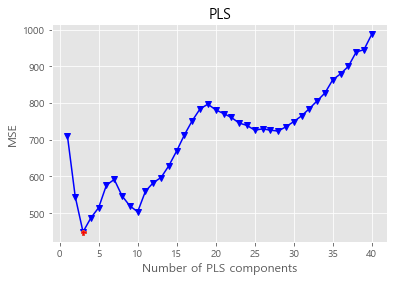

In [123]:
plot_metrics(mses, 'MSE', 'min')

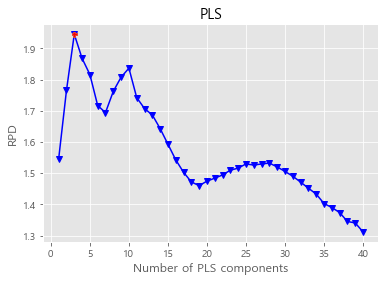

In [124]:
plot_metrics(rpds, 'RPD', 'max')

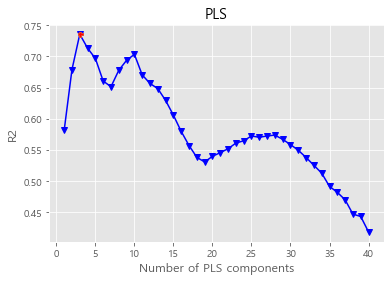

In [125]:
plot_metrics(r2s, 'R2', 'max')

In [126]:
# n_com=3, fold=4 -> R2: 0.7228, MSE: 470.7726, RPD: 1.8995
# n_com=3, fold=10 -> R2: 0.7271, MSE: 463.5409, RPD: 1.9142
# n_com=3, fold=14 -> R2: 0.7357, MSE: 448.9482, RPD: 1.9451
y_cv, r2, mse, rpd = optimise_pls_cv(X, y, 3, 14)

In [127]:
#metric
print('R2: %0.4f, MSE: %0.4f, RPD: %0.4f' %(r2, mse, rpd))

R2: 0.7357, MSE: 448.9482, RPD: 1.9451


In [128]:
#model fit
pls_model_1 = PLSRegression(n_components=3).fit(X, y)

In [129]:
#VIP score 
def vip(model):
  t = model.x_scores_
  w = model.x_weights_
  q = model.y_loadings_
  p, h = w.shape
  vips = np.zeros((p,))
  s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
  total_s = np.sum(s)
  for i in range(p):
      weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
      vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
  return vips

In [130]:
vip_score_1 = vip(pls_model_1)

In [131]:
col_1 = {'feature_name': seoul.columns[2:-3], 'vip_score': vip_score_1}
vip_score_1 = pd.DataFrame(data=col_1)
vip_score_1

,feature_name,vip_score
0,인구,0.974886
1,세대수,0.864183
2,성비,0.889249
3,면적,1.294443
4,가구수,0.819040
...,...,...
83,연도별_20대_평균_상권_매출금액,0.336857
84,연도별_30대_평균_상권_매출금액,0.632936
85,연도별_40대_평균_상권_매출금액,1.006263
86,연도별_50대_평균_상권_매출금액,0.801590


In [135]:
#PLSR 관련 논문을 근거로 vip_score 1.0이상의 피처만 선별 > 38개
vip_score_1 = vip_score_1[vip_score_1['vip_score']>=0.5].reset_index(drop=True).sort_values(by='vip_score', ascending=False)
vip_score_1 = vip_score_1.reset_index(drop=True)
vip_score_1['rank'] = vip_score_1['vip_score'].rank(method='average', ascending=False)
vip_score_1['rank_score'] =  vip_score_1['vip_score'].rank(method='average', ascending=True)
vip_score_1

,feature_name,vip_score,rank,rank_score
0,점포수,2.380290,1.0,73.0
1,연도별_평균_상권_매출금액,1.871046,2.0,72.0
2,다가구주택_평균실거래가,1.553422,3.0,71.0
3,다가구주택_월세평균임대료액,1.542435,4.0,70.0
4,전세평균보증금액,1.529196,5.0,69.0
...,...,...,...,...
68,혼인률,0.588673,69.0,5.0
69,다가구주택_전세거래수,0.560804,70.0,4.0
70,연도별_수요일_평균_상권_매출금액,0.556814,71.0,3.0
71,지가변동률,0.553941,72.0,2.0


In [136]:
#요인별 피처이름 정의
feature_selection = vip_score_1['feature_name'].to_list()

feature_economy = ['연도별_평균_상권_매출금액','연도별_주중_평균_상권_매출금액','연도별_주말_평균_상권_매출금액',
 '연도별_월요일_평균_상권_매출금액','연도별_화요일_평균_상권_매출금액',
 '연도별_수요일_평균_상권_매출금액','연도별_목요일_평균_상권_매출금액','연도별_금요일_평균_상권_매출금액',
 '연도별_토요일_평균_상권_매출금액','연도별_일요일_평균_상권_매출금액',
 '연도별_00_06_시간대_평균_상권_매출금액','연도별_06_11_시간대_평균_상권_매출금액','연도별_11_14_시간대_평균_상권_매출금액',
 '연도별_14_17_시간대_평균_상권_매출금액','연도별_17_21_시간대_평균_상권_매출금액','연도별_21_24_시간대_평균_상권_매출금액','연도별_남성_평균_상권_매출금액','연도별_여성_평균_상권_매출금액','연도별_10대_평균_상권_매출금액','연도별_20대_평균_상권_매출금액',
 '연도별_30대_평균_상권_매출금액','연도별_40대_평균_상권_매출금액','연도별_50대_평균_상권_매출금액','연도별_60대이상_평균_상권_매출금액']
feature_population = ['인구','세대수','성비','면적','가구수','one','출생건수','사망건수','혼인건수','이혼건수','세대수_1인','면적대비1인세대','외국인비율','인구밀도','세대당인구','출생률','사망률','혼인률','이혼률','one비율','인구대비1인가구','면적대비1인가구']
feature_dwell = ['주택수','단독주택수','다가구주택수','아파트수','월세거래수','월세평균임대면적','월세평균보증금액','월세평균임대료액','다가구주택_월세거래수','다가구주택_월세평균임대면적','다가구주택_월세평균보증금액','다가구주택_월세평균임대료액','전세거래수','전세평균임대면적','전세평균보증금액','다가구주택_전세거래수','아파트_전세거래수','다가구주택_전세평균임대면적','아파트_전세평균임대면적','다가구주택_전세평균보증금액','아파트_전세평균보증금액','임대거래수','실거래수','평균실거래가','평균거래면적','다가구주택_실거래수','다가구주택_평균실거래가','다가구주택_평균거래면적','아파트_실거래수','아파트_평균실거래가','아파트_평균거래면적','지가변동률','아파트비율','단독주택비율','단독주택_내_다가구주택_비율','월세비율','다가구주택_전월세비율','다가구주택_실거래비율','아파트_실거래비율']

intersection_economy = list(set(feature_selection) & set(feature_economy))
intersection_population = list(set(feature_selection) & set(feature_population))
intersection_dwell = list(set(feature_selection) & set(feature_dwell))

In [137]:
#요인별 점수통합
def sigma(N):
    ret = 0
    for n in range(1, N+1):
        ret += n
    return ret

economy_score_1 = (vip_score_1[vip_score_1['feature_name'].apply(lambda x : x in feature_economy)==True]['rank_score'].sum()/sigma(38)).round(3)
population_score_1 = (vip_score_1[vip_score_1['feature_name'].apply(lambda x : x in feature_population)==True]['rank_score'].sum()/sigma(38)).round(3)
dwell_score_1 = (vip_score_1[vip_score_1['feature_name'].apply(lambda x : x in feature_dwell)==True]['rank_score'].sum()/sigma(38)).round(3)

factor_score = [economy_score_1,population_score_1,dwell_score_1]

In [138]:
col = {'factor_name': ['경제','인구','주거'], '가중치': factor_score}
factor_total = pd.DataFrame(data=col)
factor_total

,factor_name,가중치
0,경제,0.408
1,인구,0.711
2,주거,2.228


In [139]:
#위험 지수 산출을 위한 광진구 행정동 데이터 병합
feature_selection.append('행정동')
gwangjin_GT = gwangjin[feature_selection]
gwangjin_GT.head()

,점포수,연도별_평균_상권_매출금액,다가구주택_평균실거래가,다가구주택_월세평균임대료액,전세평균보증금액,다가구주택_전세평균임대면적,월세평균임대료액,월세평균보증금액,다가구주택_월세평균보증금액,인력수,...,연도별_여성_평균_상권_매출금액,연도별_일요일_평균_상권_매출금액,연도별_화요일_평균_상권_매출금액,사망건수,혼인률,다가구주택_전세거래수,연도별_수요일_평균_상권_매출금액,지가변동률,연도별_주말_평균_상권_매출금액,행정동
0,0.451910,0.208823,0.307143,0.289252,0.140739,0.205735,0.255226,0.080361,0.151185,0.283841,...,0.224978,0.167933,0.265531,0.180291,0.233712,0.121986,0.194301,0.170635,0.182117,화양동
1,0.421407,0.299280,0.230497,0.264439,0.155191,0.238185,0.226287,0.109451,0.196874,0.189088,...,0.292536,0.315471,0.275103,0.251392,0.226339,0.130756,0.304598,0.185738,0.305193,군자동
2,0.216321,0.251480,0.191516,0.248534,0.168696,0.257771,0.214963,0.142083,0.279063,0.267562,...,0.243912,0.201505,0.220950,0.177752,0.425366,0.376855,0.197481,0.239155,0.237586,중곡1동
3,0.169725,0.185738,0.191516,0.248534,0.168696,0.257771,0.214963,0.142083,0.279063,0.185332,...,0.209874,0.205015,0.000000,0.261549,0.268142,0.376855,0.193393,0.239155,0.180113,중곡2동
4,0.183978,0.201845,0.191516,0.248534,0.168696,0.257771,0.214963,0.142083,0.279063,0.250865,...,0.197318,0.169728,0.177539,0.236156,0.249818,0.376855,0.203665,0.239155,0.180622,중곡3동


In [140]:
#일반쓰레기 위험지수 산출
gwangjin_GT['위험지수_일반쓰레기'] = 0.408*gwangjin_GT[intersection_economy].mean(axis=1) \
                                  + 0.711*gwangjin_GT[intersection_population].mean(axis=1) \
                                  + 2.228*gwangjin_GT[intersection_dwell].mean(axis=1)
gwangjin_GT = gwangjin_GT[['행정동','위험지수_일반쓰레기']]
gwangjin_GT

,행정동,위험지수_일반쓰레기
0,화양동,0.696943
1,군자동,0.752744
2,중곡1동,0.734152
3,중곡2동,0.727098
4,중곡3동,0.726282
5,중곡4동,0.781053
6,능동,0.735524
7,광장동,0.854428
8,자양1동,0.887465
9,자양2동,0.858644


- 음식물류폐기물량

In [57]:
y = seoul['음식물류폐기물량'].values
X = seoul.iloc[:,2:-3].values

In [92]:
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 41)
for n_comp in xticks:
    y_cv, r2, mse, rpd = optimise_pls_cv(X, y, n_comp, 10)
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)

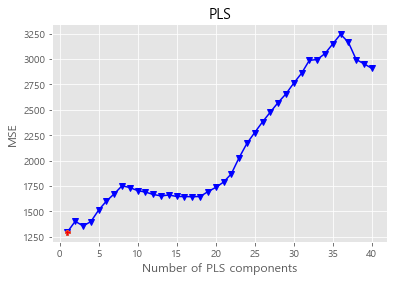

In [93]:
plot_metrics(mses, 'MSE', 'min')

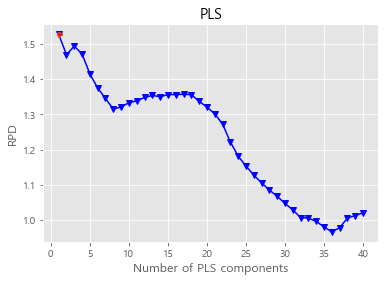

In [94]:
plot_metrics(rpds, 'RPD', 'max')

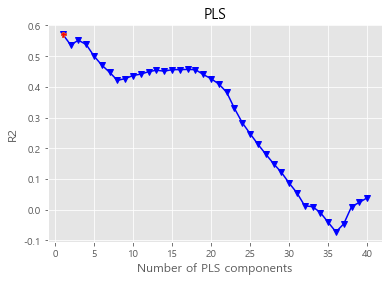

In [95]:
plot_metrics(r2s, 'R2', 'max')

In [96]:
# n_com=1, fold=3 ->  R2: 0.5876, MSE: 1248.1172, RPD: 1.5571
y_cv, r2, mse, rpd = optimise_pls_cv(X, y, 1, 10)

In [97]:
#metric
print('R2: %0.4f, MSE: %0.4f, RPD: %0.4f' %(r2, mse, rpd))

R2: 0.5715, MSE: 1296.7517, RPD: 1.5277


In [103]:
#model fit
pls_model_3 = PLSRegression(n_components=1).fit(X, y)

In [104]:
vip_score_3 = vip(pls_model_3)

In [105]:
col_3 = {'feature_name': seoul.columns[2:-3], 'vip_score': vip_score_3}
vip_score_3 = pd.DataFrame(data=col_3)
vip_score_3

,feature_name,vip_score
0,인구,1.552310
1,세대수,1.401563
2,성비,0.681080
3,면적,1.553314
4,가구수,1.371474
...,...,...
83,연도별_20대_평균_상권_매출금액,0.553761
84,연도별_30대_평균_상권_매출금액,0.386464
85,연도별_40대_평균_상권_매출금액,1.079982
86,연도별_50대_평균_상권_매출금액,0.373381


In [109]:
#PLSR 관련 논문을 근거로 vip_score 1.0이상의 피처만 선별 > 36개
vip_score_3 = vip_score_3[vip_score_3['vip_score']>=0.5].reset_index(drop=True).sort_values(by='vip_score', ascending=False)
vip_score_3 = vip_score_3.reset_index(drop=True)
vip_score_3['rank'] = vip_score_3['vip_score'].rank(method='average', ascending=False)
vip_score_3['rank_score'] =  vip_score_3['vip_score'].rank(method='average', ascending=True)
vip_score_3

,feature_name,vip_score,rank,rank_score
0,아파트_전세거래수,1.808036,1.0,67.0
1,임대거래수,1.737184,2.0,66.0
2,전세거래수,1.710294,3.0,65.0
3,출생건수,1.679700,4.0,64.0
4,연도별_평균_상권_매출금액,1.652536,5.0,63.0
...,...,...,...,...
62,연도별_주말_평균_상권_매출금액,0.606186,63.0,5.0
63,연도별_06_11_시간대_평균_상권_매출금액,0.601438,64.0,4.0
64,연도별_화요일_평균_상권_매출금액,0.559836,65.0,3.0
65,연도별_20대_평균_상권_매출금액,0.553761,66.0,2.0


In [110]:
#요인별 피처이름 정의
feature_selection = vip_score_3['feature_name'].to_list()

feature_economy = ['연도별_평균_상권_매출금액','연도별_주중_평균_상권_매출금액','연도별_주말_평균_상권_매출금액',
 '연도별_월요일_평균_상권_매출금액','연도별_화요일_평균_상권_매출금액',
 '연도별_수요일_평균_상권_매출금액','연도별_목요일_평균_상권_매출금액','연도별_금요일_평균_상권_매출금액',
 '연도별_토요일_평균_상권_매출금액','연도별_일요일_평균_상권_매출금액',
 '연도별_00_06_시간대_평균_상권_매출금액','연도별_06_11_시간대_평균_상권_매출금액','연도별_11_14_시간대_평균_상권_매출금액',
 '연도별_14_17_시간대_평균_상권_매출금액','연도별_17_21_시간대_평균_상권_매출금액','연도별_21_24_시간대_평균_상권_매출금액','연도별_남성_평균_상권_매출금액','연도별_여성_평균_상권_매출금액','연도별_10대_평균_상권_매출금액','연도별_20대_평균_상권_매출금액',
 '연도별_30대_평균_상권_매출금액','연도별_40대_평균_상권_매출금액','연도별_50대_평균_상권_매출금액','연도별_60대이상_평균_상권_매출금액']
feature_population = ['인구','세대수','성비','면적','가구수','one','출생건수','사망건수','혼인건수','이혼건수','세대수_1인','면적대비1인세대','외국인비율','인구밀도','세대당인구','출생률','사망률','혼인률','이혼률','one비율','인구대비1인가구','면적대비1인가구']
feature_dwell = ['주택수','단독주택수','다가구주택수','아파트수','월세거래수','월세평균임대면적','월세평균보증금액','월세평균임대료액','다가구주택_월세거래수','다가구주택_월세평균임대면적','다가구주택_월세평균보증금액','다가구주택_월세평균임대료액','전세거래수','전세평균임대면적','전세평균보증금액','다가구주택_전세거래수','아파트_전세거래수','다가구주택_전세평균임대면적','아파트_전세평균임대면적','다가구주택_전세평균보증금액','아파트_전세평균보증금액','임대거래수','실거래수','평균실거래가','평균거래면적','다가구주택_실거래수','다가구주택_평균실거래가','다가구주택_평균거래면적','아파트_실거래수','아파트_평균실거래가','아파트_평균거래면적','지가변동률','아파트비율','단독주택비율','단독주택_내_다가구주택_비율','월세비율','다가구주택_전월세비율','다가구주택_실거래비율','아파트_실거래비율']

intersection_economy = list(set(feature_selection) & set(feature_economy))
intersection_population = list(set(feature_selection) & set(feature_population))
intersection_dwell = list(set(feature_selection) & set(feature_dwell))

In [111]:
economy_score_3 = (vip_score_3[vip_score_3['feature_name'].apply(lambda x : x in feature_economy)==True]['rank_score'].sum()/sigma(36)).round(3)
population_score_3 = (vip_score_3[vip_score_3['feature_name'].apply(lambda x : x in feature_population)==True]['rank_score'].sum()/sigma(36)).round(3)
dwell_score_3 = (vip_score_3[vip_score_3['feature_name'].apply(lambda x : x in feature_dwell)==True]['rank_score'].sum()/sigma(36)).round(3)

factor_score = [economy_score_3,population_score_3,dwell_score_3]

In [112]:
col = {'factor_name': ['경제','인구','주거'], '가중치': factor_score}
factor_total = pd.DataFrame(data=col)
factor_total

,factor_name,가중치
0,경제,0.419
1,인구,0.892
2,주거,1.872


In [113]:
#위험 지수 산출을 위한 광진구 행정동 데이터 병합
feature_selection.append('행정동')
gwangjin_FT = gwangjin[feature_selection]
gwangjin_FT.head()

,아파트_전세거래수,임대거래수,전세거래수,출생건수,연도별_평균_상권_매출금액,월세거래수,연도별_남성_평균_상권_매출금액,사망률,아파트수,주택수,...,다가구주택_전세평균보증금액,외국인비율,연도별_11_14_시간대_평균_상권_매출금액,다가구주택_월세평균임대료액,연도별_주말_평균_상권_매출금액,연도별_06_11_시간대_평균_상권_매출금액,연도별_화요일_평균_상권_매출금액,연도별_20대_평균_상권_매출금액,연도별_60대이상_평균_상권_매출금액,행정동
0,0.022502,0.119306,0.081685,0.088698,0.208823,0.161815,0.180435,0.177169,0.100393,0.215029,...,0.177041,0.404600,0.169636,0.289252,0.182117,0.160022,0.265531,0.256945,0.196009,화양동
1,0.012982,0.088991,0.075137,0.203766,0.299280,0.104503,0.318138,0.280853,0.057504,0.184983,...,0.228611,0.336325,0.297741,0.264439,0.305193,0.281910,0.275103,0.426007,0.352252,군자동
2,0.029858,0.293971,0.290114,0.227739,0.251480,0.297441,0.211090,0.250618,0.010925,0.146695,...,0.280458,0.093510,0.203611,0.248534,0.237586,0.225066,0.220950,0.169076,0.233082,중곡1동
3,0.029858,0.293971,0.290114,0.225341,0.185738,0.297441,0.182028,0.265395,0.022145,0.202442,...,0.280458,0.062035,0.176592,0.248534,0.180113,0.144989,0.000000,0.171296,0.177634,중곡2동
4,0.029858,0.293971,0.290114,0.165410,0.201845,0.297441,0.205539,0.315181,0.034104,0.157130,...,0.280458,0.058176,0.161873,0.248534,0.180622,0.152164,0.177539,0.206667,0.186496,중곡3동


In [114]:
#음식물류폐기물 위험지수 산출
gwangjin_FT['위험지수_음식물류폐기물'] = 0.419*gwangjin_FT[intersection_economy].mean(axis=1) \
                                         + 0.892*gwangjin_FT[intersection_population].mean(axis=1) \
                                         + 1.872*gwangjin_FT[intersection_dwell].mean(axis=1)
gwangjin_FT = gwangjin_FT[['행정동','위험지수_음식물류폐기물']]
gwangjin_FT

,행정동,위험지수_음식물류폐기물
0,화양동,0.687873
1,군자동,0.725721
2,중곡1동,0.672306
3,중곡2동,0.656512
4,중곡3동,0.658821
5,중곡4동,0.738023
6,능동,0.697631
7,광장동,0.851381
8,자양1동,0.837088
9,자양2동,0.810812


In [ ]:
# 최종 지수 병합
result = gwangjin_GT.merge(gwangjin_RT, on='행정동').merge(gwangjin_FT, on='행정동')
result['지수순위_일반쓰레기'] = result['위험지수_일반쓰레기'].rank(method='average', ascending=False)
result['지수순위_재활용폐기물'] = result['위험지수_재활용폐기물'].rank(method='average', ascending=False)
result['지수순위_음식물류폐기물'] = result['위험지수_음식물류폐기물'].rank(method='average', ascending=False)
result

In [ ]:
# PLSR 특성상 중요하지 않은 변수도 지수 산출에 포함되기에 다중선형회귀분석모형 학습 결과로 지수를 산출한다.